## Flood Detection Project

Goal: finetune various vision transformer models + pretrained CNNs on combined flood dataset and test results

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image
from sklearn.model_selection import train_test_split
from glob import glob
import numpy as np
#import rasterio
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.optim as optim
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
import timm
import zipfile
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score

In [ ]:
# Change zip file name depending on desired dataset
zip_name = 'Sen2-Split-Dataset'
#zip_name = 'KF-Dataset'
zip_path = f'/content/drive/MyDrive/Colab Notebooks/CS 563/Project/Data/{zip_name}.zip'
extract_path = f'/content/flood-dataset'  # where to extract locally
#zip_name = 'Comb-Dataset'
dataset_src_path = f'/content/flood-dataset/{zip_name}'
checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/CS 563/Project/Model-Checkpoints'

In [ ]:
if not os.path.exists(extract_path):
    print("Extracting dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(extract_path)
    print("Extraction done!")

Extracting dataset...
Extraction done!


In [ ]:
# ImageNet mean and std
# mean = [0.485, 0.456, 0.406]
# std  = [0.229, 0.224, 0.225]

# ViT mean/std different from ImageNet-1K (all other models used)
mean = [0.5 ,0.5, 0.5]
std = [0.5, 0.5, 0.5]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Load datasets
train_dataset = ImageFolder(os.path.join(dataset_src_path, 'train'), transform=train_transform)
test_dataset = ImageFolder(os.path.join(dataset_src_path, 'test'), transform=test_transform)

# Split datasets
labels = np.array([label for _, label in train_dataset.samples])  # 1 for flooded, 0 for non-flooded
flooded_idx = np.where(labels == 1)[0]
non_flooded_idx = np.where(labels == 0)[0]

val_ratio = 0.2
np.random.seed(42)

# Determine how many to put in validation set
num_flooded_val = int(len(flooded_idx) * val_ratio)
num_nonflooded_val = int(len(non_flooded_idx) * val_ratio)

# Sample validation indices
val_flooded_idx = np.random.choice(flooded_idx, num_flooded_val, replace=False)
val_nonflooded_idx = np.random.choice(non_flooded_idx, num_nonflooded_val, replace=False)
val_idx = np.concatenate([val_flooded_idx, val_nonflooded_idx])
train_idx = np.setdiff1d(np.arange(len(train_dataset)), val_idx)

train_subset = Subset(train_dataset, train_idx)
val_subset = Subset(train_dataset, val_idx)

# WeightedRandomSampler for training => deal with class imbalance
train_labels = [train_dataset.samples[i][1] for i in train_idx]
class_counts = np.bincount(train_labels)
class_weights = 1.0 / class_counts
sample_weights = [class_weights[label] for label in train_labels]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# DataLoaders
train_loader = DataLoader(train_subset, batch_size=32, sampler=sampler, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")

Train batches: 38, Val batches: 10, Test batches: 13


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=5, learning_rate=0.001, device='cuda', model_name=None, resume_path=None, checkpoint_dir=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    model.to(device)
    model.train()

    train_labels = []
    for batch in train_loader:
        _, labels = batch
        train_labels.extend(labels.numpy())
    train_labels = np.array(train_labels)
    num_pos = train_labels.sum()
    num_neg = len(train_labels) - num_pos
    pos_weight = num_neg / num_pos
    print(f"Using pos_weight = {pos_weight:.2f}")
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight).to(device))

    #optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.05)
    scaler = torch.cuda.amp.GradScaler()
    #scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)


    train_losses = []
    val_accuracies = []
    val_losses = []
    best_thresholds = []

    start_epoch = 0

    if checkpoint_dir is None:
        checkpoint_dir = './checkpoints'
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Resume checkpoint if provided
    if resume_path:
        checkpoint = torch.load(resume_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        scaler.load_state_dict(checkpoint['scaler_state_dict'])
        train_losses = checkpoint['train_losses']
        val_accuracies = checkpoint['val_accuracies']
        val_losses = checkpoint['val_losses']
        start_epoch = checkpoint['epoch'] + 1
        print(f"Resumed training from epoch {start_epoch}")

    start_time = time.time()

    for epoch in range(start_epoch, start_epoch + num_epochs):
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        print(f"Epoch {epoch + 1} - Training")

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.unsqueeze(1).float().to(device, non_blocking=True)  # (B,1) for BCE

            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * inputs.size(0)

            # Predictions
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

            if batch_idx % 5 == 0:
                batch_loss = running_loss / (batch_idx + 1)
                batch_acc = (correct_preds / total_preds) * 100
                print(f"  Batch {batch_idx + 1}/{len(train_loader)} - Loss: {batch_loss:.4f}, Acc: {batch_acc:.2f}%")

        avg_loss = running_loss / len(train_loader.dataset)
        train_accuracy = (correct_preds / total_preds) * 100
        train_losses.append(avg_loss)
        print(f"Epoch {epoch + 1} - Train Loss: {avg_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

        scheduler.step(avg_loss)
        print(f"Learning Rate after Epoch {epoch + 1}: {optimizer.param_groups[0]['lr']:.6f}")

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss_total = 0.0
        all_val_labels = []
        all_val_outputs = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.unsqueeze(1).float().to(device, non_blocking=True)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss_total += loss.item() * inputs.size(0)

                #preds = (torch.sigmoid(outputs) > 0.5).float()
                #val_correct += (preds == labels).sum().item()
                #val_total += labels.size(0)

                all_val_labels.extend(labels.cpu().numpy())
                all_val_outputs.extend(torch.sigmoid(outputs).cpu().numpy())

        all_val_labels = np.array(all_val_labels)
        all_val_outputs = np.array(all_val_outputs)
        best_thresh = 0.5
        best_f1 = 0
        for thresh in np.linspace(0.1, 0.9, 81):
            preds = (all_val_outputs > thresh).astype(int)
            f1 = f1_score(all_val_labels, preds)
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh

        best_thresholds.append(best_thresh)
        val_preds = (all_val_outputs > best_thresh).astype(int)
        val_acc = (val_preds == all_val_labels).mean()
        val_loss = val_loss_total / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # ----- Metrics -----
        precision = precision_score(all_val_labels, val_preds)
        recall = recall_score(all_val_labels, val_preds)
        f1 = f1_score(all_val_labels, val_preds)
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}, Best Threshold: {best_thresh:.2f}")

        '''
        val_loss = val_loss_total / len(val_loader.dataset)
        val_acc = val_correct / val_total
        val_accuracies.append(val_acc)
        val_losses.append(val_loss)
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")'''

        model.train()
        torch.cuda.empty_cache()

        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0 and model_name is not None:
            ckpt_path = os.path.join(checkpoint_dir, f"{model_name}_epoch{epoch + 1}.pt")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'scaler_state_dict': scaler.state_dict(),
                'train_losses': train_losses,
                'val_accuracies': val_accuracies,
                'val_losses': val_losses
            }, ckpt_path)
            print(f"Saved checkpoint: {ckpt_path}")

    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time:.2f} seconds")

    # Plot Loss and Accuracy
    plt.figure(figsize=(10,5))
    plt.plot(range(1, start_epoch + num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, start_epoch + num_epochs + 1), val_accuracies, label='Val Accuracy')
    plt.plot(range(1, start_epoch + num_epochs + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss / Accuracy')
    plt.title(f'{model_name} Training')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, train_losses, val_accuracies

def test_model(model, test_loader, device='cuda'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    model.to(device)
    model.eval()

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.unsqueeze(1).float().to(device, non_blocking=True)

            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).float()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    all_labels = np.array(all_labels).flatten()
    all_preds = np.array(all_preds).flatten()

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    # Overall accuracy
    accuracy = (all_preds == all_labels).mean()
    print(f"Test Accuracy: {accuracy:.4f}")

    return cm, accuracy

In [ ]:
models = {
    "ViT": "vit_tiny_patch16_224", #.augreg_in21k_ft_in1k",
    "DeiT": "deit_tiny_patch16_224", #.fb_in1k",
    "CaiT": "cait_xxs24_224", #.fb_dist_in1k",
    "SwinT": "swin_tiny_patch4_window7_224",
    "ResNet": "resnet50"
}

In [ ]:
for model_name in models.values():
  model = timm.create_model(model_name, pretrained=True)
  num_params = sum(p.numel() for p in model.parameters())
  print(f"{model_name} parameters: {num_params:,}")

vit_tiny_patch16_224 parameters: 5,717,416
deit_tiny_patch16_224 parameters: 5,717,416
cait_xxs24_224 parameters: 11,956,264
swin_tiny_patch4_window7_224 parameters: 28,288,354


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

resnet50 parameters: 25,557,032


In [ ]:
m = timm.create_model(models['ViT'], pretrained=True)
print(m.pretrained_cfg['mean'])
print(m.pretrained_cfg['std'])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

(0.5, 0.5, 0.5)
(0.5, 0.5, 0.5)


Using device: cuda
Using pos_weight = 0.97
Epoch 1 - Training


/tmp/ipython-input-1338911716.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-1338911716.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Batch 1/19 - Loss: 24.5920, Acc: 46.88%
  Batch 6/19 - Loss: 24.6512, Acc: 46.35%
  Batch 11/19 - Loss: 23.0186, Acc: 52.84%
  Batch 16/19 - Loss: 22.1767, Acc: 57.62%
Epoch 1 - Train Loss: 0.6813, Accuracy: 58.22%
Learning Rate after Epoch 1: 0.000010


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.4576, Accuracy: 0.8851, Precision: 0.902, Recall: 0.967, F1: 0.933, Best Threshold: 0.37
Epoch 2 - Training


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1338911716.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Batch 1/19 - Loss: 16.8805, Acc: 75.00%
  Batch 6/19 - Loss: 16.1619, Acc: 75.52%
  Batch 11/19 - Loss: 15.6712, Acc: 75.00%
  Batch 16/19 - Loss: 14.8599, Acc: 77.93%
Epoch 2 - Train Loss: 0.4535, Accuracy: 78.86%
Learning Rate after Epoch 2: 0.000010


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.3113, Accuracy: 0.9324, Precision: 0.931, Recall: 0.992, F1: 0.961, Best Threshold: 0.33
Epoch 3 - Training


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1338911716.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Batch 1/19 - Loss: 13.6030, Acc: 84.38%
  Batch 6/19 - Loss: 11.1777, Acc: 87.50%
  Batch 11/19 - Loss: 10.8400, Acc: 87.22%
  Batch 16/19 - Loss: 11.4047, Acc: 85.35%
Epoch 3 - Train Loss: 0.3431, Accuracy: 86.91%
Learning Rate after Epoch 3: 0.000010


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.2608, Accuracy: 0.9662, Precision: 0.976, Recall: 0.984, F1: 0.980, Best Threshold: 0.37
Epoch 4 - Training


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1338911716.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Batch 1/19 - Loss: 6.9113, Acc: 96.88%
  Batch 6/19 - Loss: 8.1240, Acc: 92.19%
  Batch 11/19 - Loss: 8.1107, Acc: 92.33%
  Batch 16/19 - Loss: 7.9457, Acc: 92.19%
Epoch 4 - Train Loss: 0.2457, Accuracy: 92.62%
Learning Rate after Epoch 4: 0.000010


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1743, Accuracy: 0.9730, Precision: 0.976, Recall: 0.992, F1: 0.984, Best Threshold: 0.44
Epoch 5 - Training


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1338911716.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Batch 1/19 - Loss: 6.7608, Acc: 93.75%
  Batch 6/19 - Loss: 7.1568, Acc: 91.67%
  Batch 11/19 - Loss: 7.0295, Acc: 92.33%
  Batch 16/19 - Loss: 6.8450, Acc: 92.97%
Epoch 5 - Train Loss: 0.2277, Accuracy: 92.45%
Learning Rate after Epoch 5: 0.000010


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1366, Accuracy: 0.9730, Precision: 0.976, Recall: 0.992, F1: 0.984, Best Threshold: 0.52
Saved checkpoint: /content/drive/MyDrive/Colab Notebooks/CS 563/Project/Model-Checkpoints/vit_tiny_patch16_224_epoch5.pt
Epoch 6 - Training


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1338911716.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Batch 1/19 - Loss: 5.5236, Acc: 93.75%
  Batch 6/19 - Loss: 5.5734, Acc: 95.31%
  Batch 11/19 - Loss: 6.2086, Acc: 93.75%
  Batch 16/19 - Loss: 5.6316, Acc: 94.14%
Epoch 6 - Train Loss: 0.1750, Accuracy: 93.96%
Learning Rate after Epoch 6: 0.000010


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1413, Accuracy: 0.9662, Precision: 0.961, Recall: 1.000, F1: 0.980, Best Threshold: 0.12
Epoch 7 - Training


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1338911716.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Batch 1/19 - Loss: 4.0923, Acc: 96.88%
  Batch 6/19 - Loss: 3.3730, Acc: 98.44%
  Batch 11/19 - Loss: 3.8547, Acc: 96.88%
  Batch 16/19 - Loss: 3.9420, Acc: 97.46%
Epoch 7 - Train Loss: 0.1208, Accuracy: 97.48%
Learning Rate after Epoch 7: 0.000010


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1274, Accuracy: 0.9662, Precision: 0.968, Recall: 0.992, F1: 0.980, Best Threshold: 0.42
Epoch 8 - Training


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1338911716.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Batch 1/19 - Loss: 3.0836, Acc: 100.00%
  Batch 6/19 - Loss: 3.2965, Acc: 97.92%
  Batch 11/19 - Loss: 3.6495, Acc: 97.16%
  Batch 16/19 - Loss: 3.3892, Acc: 97.66%
Epoch 8 - Train Loss: 0.1043, Accuracy: 97.32%
Learning Rate after Epoch 8: 0.000010


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1308, Accuracy: 0.9662, Precision: 0.961, Recall: 1.000, F1: 0.980, Best Threshold: 0.17
Epoch 9 - Training


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1338911716.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Batch 1/19 - Loss: 1.7977, Acc: 100.00%
  Batch 6/19 - Loss: 2.3491, Acc: 98.44%
  Batch 11/19 - Loss: 2.8877, Acc: 97.16%
  Batch 16/19 - Loss: 2.8132, Acc: 97.85%
Epoch 9 - Train Loss: 0.0896, Accuracy: 97.82%
Learning Rate after Epoch 9: 0.000010


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1398, Accuracy: 0.9662, Precision: 0.961, Recall: 1.000, F1: 0.980, Best Threshold: 0.10
Epoch 10 - Training


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1338911716.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Batch 1/19 - Loss: 1.0884, Acc: 100.00%
  Batch 6/19 - Loss: 2.6827, Acc: 97.92%
  Batch 11/19 - Loss: 2.6326, Acc: 98.30%
  Batch 16/19 - Loss: 2.5286, Acc: 98.05%
Epoch 10 - Train Loss: 0.0783, Accuracy: 98.15%
Learning Rate after Epoch 10: 0.000010


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1302, Accuracy: 0.9662, Precision: 0.961, Recall: 1.000, F1: 0.980, Best Threshold: 0.10
Saved checkpoint: /content/drive/MyDrive/Colab Notebooks/CS 563/Project/Model-Checkpoints/vit_tiny_patch16_224_epoch10.pt

Training completed in 800.95 seconds


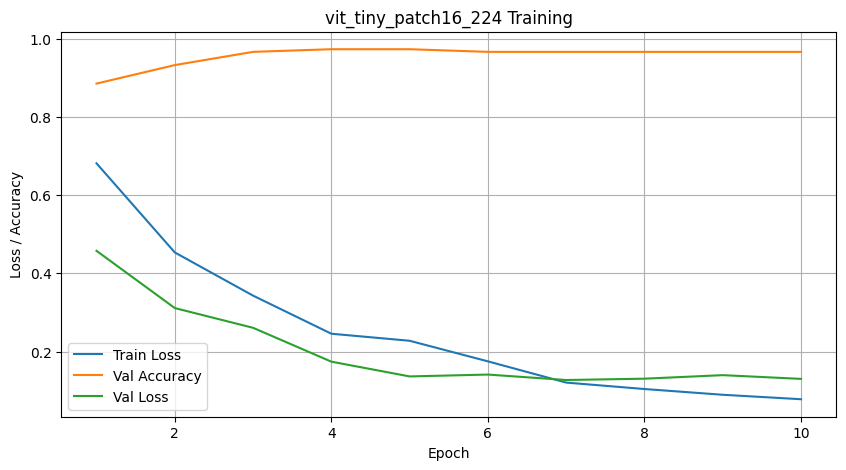

In [ ]:
vit_model_name = models["ViT"]
vit_model_trained = timm.create_model(vit_model_name, pretrained=True, num_classes=1, drop_rate=0.1, drop_path_rate=0.1)
resume_path = f'{checkpoint_dir}/{vit_model_name}_epoch5.pt'

vit_model_trained, vit_train_losses, vit_val_accuracies = train_model(
    model=vit_model_trained,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10,
    learning_rate=1e-5,
    device="cuda",
    resume_path=None,
    model_name=vit_model_name,
    checkpoint_dir=checkpoint_dir
)

Using device: cuda


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


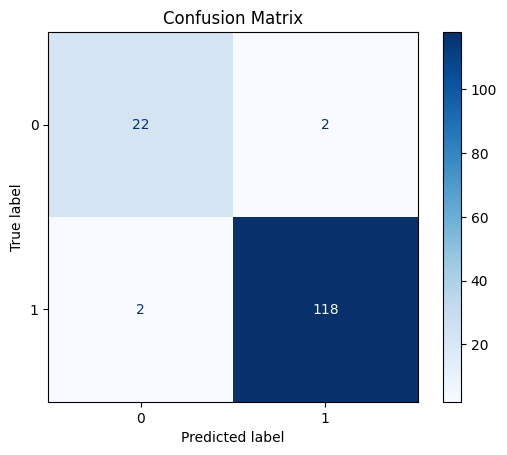

Test Accuracy: 0.9722


In [ ]:
vit_cm, vit_acc = test_model(vit_model_trained, test_loader)

Using device: cuda


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Using pos_weight = 0.92


/tmp/ipython-input-1338911716.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Resumed training from epoch 10
Epoch 11 - Training


/tmp/ipython-input-1338911716.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Batch 1/19 - Loss: 4.2850, Acc: 96.88%
  Batch 6/19 - Loss: 3.8949, Acc: 98.96%
  Batch 11/19 - Loss: 3.6152, Acc: 99.15%
  Batch 16/19 - Loss: 3.6063, Acc: 98.83%
Epoch 11 - Train Loss: 0.1072, Accuracy: 98.99%
Learning Rate after Epoch 11: 0.000100


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1706, Accuracy: 0.9595, Precision: 0.968, Recall: 0.984, F1: 0.976, Best Threshold: 0.54
Epoch 12 - Training


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1338911716.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Batch 1/19 - Loss: 5.7596, Acc: 90.62%
  Batch 6/19 - Loss: 2.8590, Acc: 96.88%
  Batch 11/19 - Loss: 3.1243, Acc: 96.88%
  Batch 16/19 - Loss: 2.8538, Acc: 97.46%
Epoch 12 - Train Loss: 0.0852, Accuracy: 97.65%
Learning Rate after Epoch 12: 0.000100


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1726, Accuracy: 0.9527, Precision: 0.946, Recall: 1.000, F1: 0.972, Best Threshold: 0.15
Epoch 13 - Training


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1338911716.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Batch 1/19 - Loss: 1.3688, Acc: 100.00%
  Batch 6/19 - Loss: 2.6893, Acc: 98.44%
  Batch 11/19 - Loss: 2.3560, Acc: 98.86%
  Batch 16/19 - Loss: 2.2581, Acc: 99.22%
Epoch 13 - Train Loss: 0.0708, Accuracy: 99.16%
Learning Rate after Epoch 13: 0.000100


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1494, Accuracy: 0.9595, Precision: 0.953, Recall: 1.000, F1: 0.976, Best Threshold: 0.31
Epoch 14 - Training


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1338911716.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Batch 1/19 - Loss: 2.3404, Acc: 100.00%
  Batch 6/19 - Loss: 1.7956, Acc: 100.00%
  Batch 11/19 - Loss: 1.6734, Acc: 100.00%
  Batch 16/19 - Loss: 1.5981, Acc: 100.00%
Epoch 14 - Train Loss: 0.0486, Accuracy: 100.00%
Learning Rate after Epoch 14: 0.000100


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1560, Accuracy: 0.9527, Precision: 0.946, Recall: 1.000, F1: 0.972, Best Threshold: 0.13
Epoch 15 - Training


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1338911716.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Batch 1/19 - Loss: 3.4283, Acc: 93.75%
  Batch 6/19 - Loss: 1.7790, Acc: 98.96%
  Batch 11/19 - Loss: 1.5939, Acc: 99.43%
  Batch 16/19 - Loss: 1.5207, Acc: 99.61%
Epoch 15 - Train Loss: 0.0541, Accuracy: 98.99%
Learning Rate after Epoch 15: 0.000100


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1455, Accuracy: 0.9595, Precision: 0.953, Recall: 1.000, F1: 0.976, Best Threshold: 0.37
Saved checkpoint: /content/drive/MyDrive/Colab Notebooks/CS 563/Project/Model-Checkpoints/resnet50_epoch15.pt

Training completed in 410.83 seconds


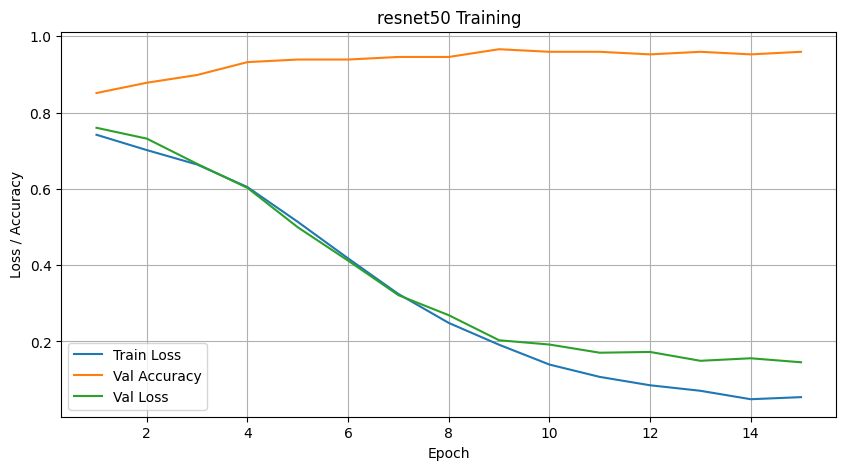

In [ ]:
cnn_model_name = models['ResNet']
cnn_model_trained = timm.create_model(cnn_model_name, pretrained=True, num_classes=1)
resume_path = f'{checkpoint_dir}/{cnn_model_name}_epoch10.pt'

cnn_model_trained, cnn_train_losses, cnn_val_accuracies = train_model(
    model=cnn_model_trained,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=5,
    learning_rate=1e-4,
    device="cuda",
    resume_path=resume_path,
    model_name=cnn_model_name,
    checkpoint_dir=checkpoint_dir
)

Using device: cuda


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


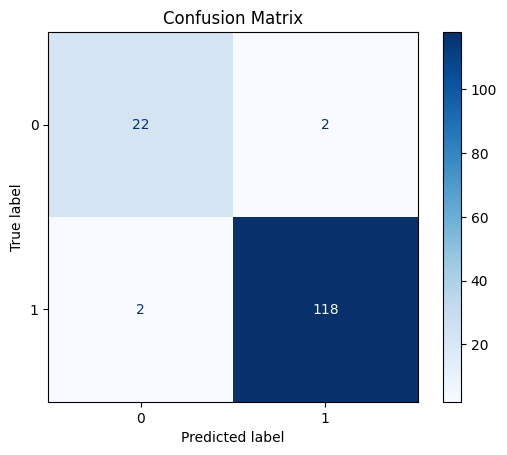

Test Accuracy: 0.9722


In [ ]:
cnn_cm, cnn_acc = test_model(cnn_model_trained, test_loader)

Using device: cuda


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Using pos_weight = 1.02


/tmp/ipython-input-1338911716.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Resumed training from epoch 5
Epoch 6 - Training


/tmp/ipython-input-1338911716.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Batch 1/19 - Loss: 2.1502, Acc: 100.00%
  Batch 6/19 - Loss: 3.0971, Acc: 98.44%
  Batch 11/19 - Loss: 3.1257, Acc: 98.30%
  Batch 16/19 - Loss: 2.9381, Acc: 98.44%
Epoch 6 - Train Loss: 0.0889, Accuracy: 98.66%
Learning Rate after Epoch 6: 0.000010


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1451, Accuracy: 0.9662, Precision: 0.961, Recall: 1.000, F1: 0.980, Best Threshold: 0.26
Epoch 7 - Training


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1338911716.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Batch 1/19 - Loss: 2.0988, Acc: 96.88%
  Batch 6/19 - Loss: 1.8404, Acc: 98.96%
  Batch 11/19 - Loss: 2.2185, Acc: 98.30%
  Batch 16/19 - Loss: 1.9011, Acc: 98.83%
Epoch 7 - Train Loss: 0.0558, Accuracy: 98.99%
Learning Rate after Epoch 7: 0.000010


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1360, Accuracy: 0.9730, Precision: 0.969, Recall: 1.000, F1: 0.984, Best Threshold: 0.15
Epoch 8 - Training


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1338911716.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Batch 1/19 - Loss: 1.8519, Acc: 96.88%
  Batch 6/19 - Loss: 1.2822, Acc: 99.48%
  Batch 11/19 - Loss: 1.1447, Acc: 99.72%
  Batch 16/19 - Loss: 1.0797, Acc: 99.80%
Epoch 8 - Train Loss: 0.0325, Accuracy: 99.83%
Learning Rate after Epoch 8: 0.000010


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1368, Accuracy: 0.9662, Precision: 0.961, Recall: 1.000, F1: 0.980, Best Threshold: 0.39

Training completed in 230.59 seconds


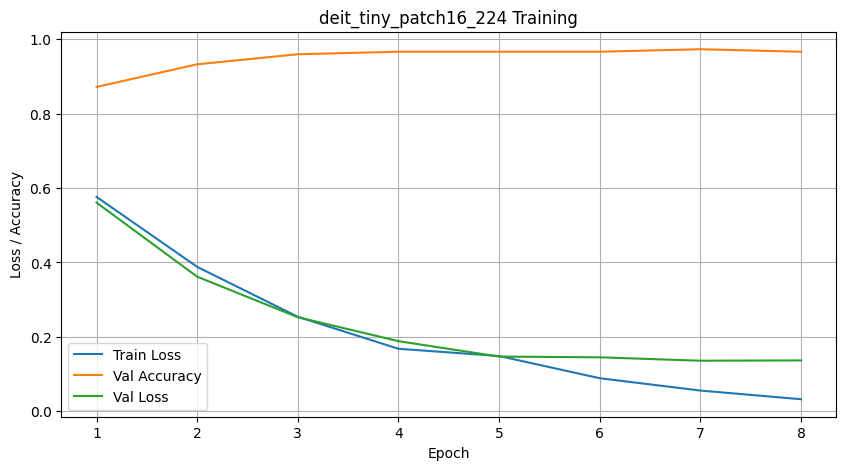

In [ ]:
deit_model_name = models["DeiT"]
deit_model_trained = timm.create_model(deit_model_name, pretrained=True, num_classes=1)
resume_path = f'{checkpoint_dir}/{deit_model_name}_epoch5.pt'

deit_model_trained, deit_train_losses, deit_val_accuracies = train_model(
    model=deit_model_trained,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=3,
    learning_rate=1e-5,
    device="cuda",
    resume_path=resume_path,
    model_name=deit_model_name,
    checkpoint_dir=checkpoint_dir
)

Using device: cuda


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


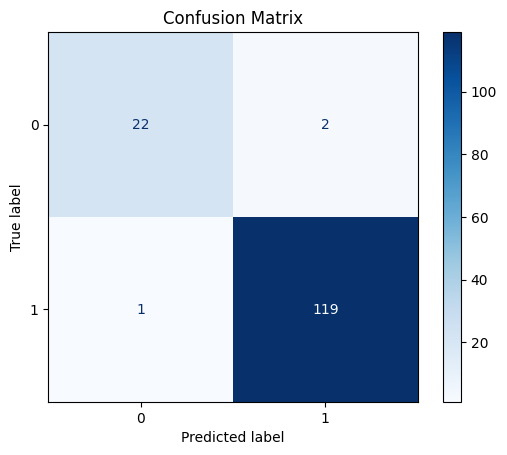

Test Accuracy: 0.9792


In [ ]:
deit_cm, deit_acc = test_model(deit_model_trained, test_loader)

Using device: cuda


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Using pos_weight = 0.90


/tmp/ipython-input-1338911716.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Resumed training from epoch 10
Epoch 11 - Training


/tmp/ipython-input-1338911716.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Batch 1/38 - Loss: 3.6674, Acc: 96.88%
  Batch 6/38 - Loss: 4.1820, Acc: 96.35%
  Batch 11/38 - Loss: 3.6933, Acc: 96.31%
  Batch 16/38 - Loss: 3.5658, Acc: 95.70%
  Batch 21/38 - Loss: 3.7029, Acc: 95.54%
  Batch 26/38 - Loss: 3.9663, Acc: 95.19%
  Batch 31/38 - Loss: 3.9421, Acc: 95.26%
  Batch 36/38 - Loss: 4.1062, Acc: 94.79%
Epoch 11 - Train Loss: 0.1279, Accuracy: 94.90%
Learning Rate after Epoch 11: 0.000010


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.2859, Accuracy: 0.8993, Precision: 0.910, Recall: 0.965, F1: 0.937, Best Threshold: 0.14

Training completed in 26.04 seconds


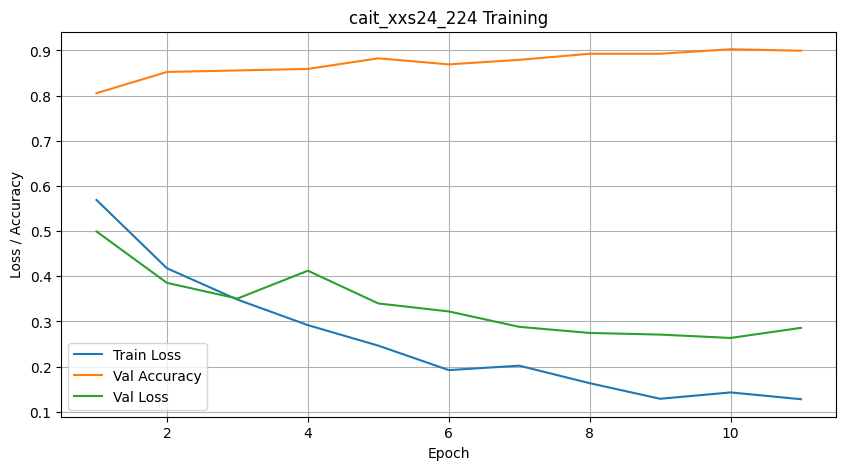

In [ ]:
cait_model_name = models["CaiT"]
cait_model_trained = timm.create_model(cait_model_name, pretrained=True, num_classes=1)
resume_path = f'{checkpoint_dir}/{cait_model_name}_epoch10.pt'

cait_model_trained, cait_train_losses, cait_val_accuracies = train_model(
    model=cait_model_trained,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=1,
    learning_rate=1e-5,
    device="cuda",
    resume_path=resume_path,
    model_name=cait_model_name,
    checkpoint_dir=checkpoint_dir
)

Using device: cuda


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


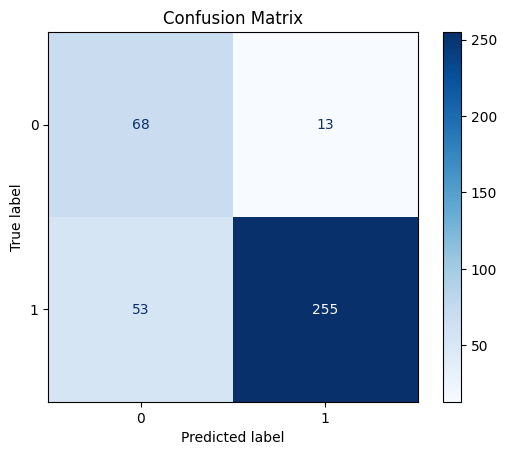

Test Accuracy: 0.8303


In [ ]:
cait_cm, cait_acc = test_model(cait_model_trained, test_loader)

Using device: cuda


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Using pos_weight = 0.90


/tmp/ipython-input-1338911716.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Resumed training from epoch 5
Epoch 6 - Training


/tmp/ipython-input-1338911716.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Batch 1/19 - Loss: 1.2980, Acc: 100.00%
  Batch 6/19 - Loss: 1.2765, Acc: 98.96%
  Batch 11/19 - Loss: 1.0869, Acc: 99.43%
  Batch 16/19 - Loss: 1.0632, Acc: 99.41%
Epoch 6 - Train Loss: 0.0332, Accuracy: 99.50%
Learning Rate after Epoch 6: 0.000010


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1610, Accuracy: 0.9595, Precision: 0.961, Recall: 0.992, F1: 0.976, Best Threshold: 0.10
Epoch 7 - Training


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1338911716.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Batch 1/19 - Loss: 0.5685, Acc: 100.00%
  Batch 6/19 - Loss: 0.6776, Acc: 99.48%
  Batch 11/19 - Loss: 0.7771, Acc: 99.43%
  Batch 16/19 - Loss: 0.7170, Acc: 99.61%
Epoch 7 - Train Loss: 0.0227, Accuracy: 99.66%
Learning Rate after Epoch 7: 0.000010


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1447, Accuracy: 0.9662, Precision: 0.976, Recall: 0.984, F1: 0.980, Best Threshold: 0.33
Epoch 8 - Training


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1338911716.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  Batch 1/19 - Loss: 2.6581, Acc: 96.88%
  Batch 6/19 - Loss: 1.0181, Acc: 98.96%
  Batch 11/19 - Loss: 1.3335, Acc: 98.01%
  Batch 16/19 - Loss: 1.1161, Acc: 98.63%
Epoch 8 - Train Loss: 0.0356, Accuracy: 98.66%
Learning Rate after Epoch 8: 0.000010


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation Loss: 0.1734, Accuracy: 0.9595, Precision: 0.961, Recall: 0.992, F1: 0.976, Best Threshold: 0.14

Training completed in 256.30 seconds


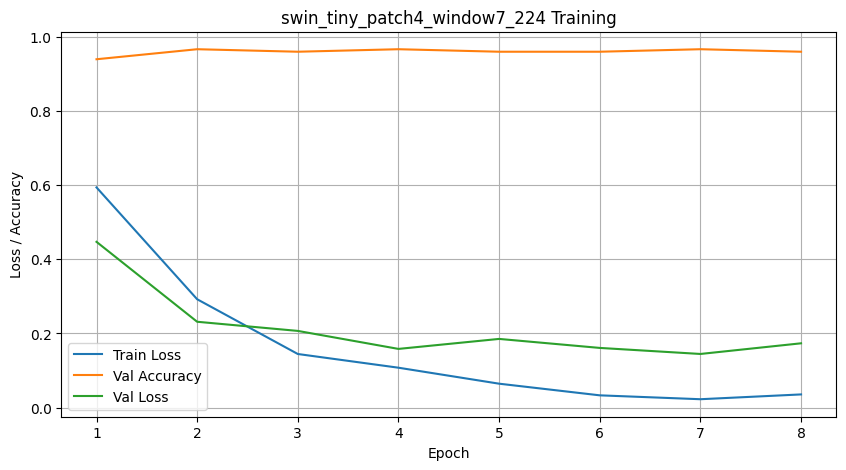

In [ ]:
swint_model_name = models["SwinT"]
swint_model_trained = timm.create_model(swint_model_name, pretrained=True, num_classes=1)
resume_path = f'{checkpoint_dir}/{swint_model_name}_epoch5.pt'

swint_model_trained, swint_train_losses, swint_val_accuracies = train_model(
    model=swint_model_trained,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=3,
    learning_rate=1e-5,
    device="cuda",
    resume_path=resume_path,
    model_name=swint_model_name,
    checkpoint_dir=checkpoint_dir
)

Using device: cuda


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


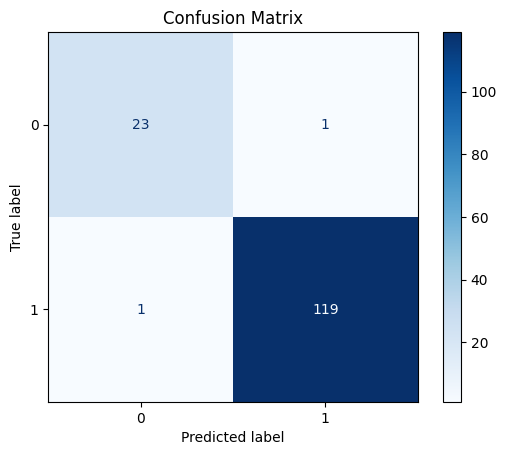

Test Accuracy: 0.9861


In [ ]:
swint_cm, swint_acc = test_model(swint_model_trained, test_loader)